Show the relationship between minimum temeperature and area of permafrost (defined from gridcells that have T$_{mean}$ < 0°C for 24 consecutive months).

In [1]:
import numpy as np
import iris
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm
import matplotlib
import matplotlib.ticker as ticker 
from matplotlib import cm
from matplotlib.colors import ListedColormap

from pyproj import Proj
from shapely.geometry import shape

import warnings
warnings.filterwarnings("ignore") ## To ignore UserWarning about collapsing a non-contagious variable

Load datasets Tmean and TNn of RCP4.5.

In [2]:
path = r"E:\Datasets_Geoengineering\RCP45_variables/"

T_mean_RCP= iris.load(path + "TSA_RCP45.all.nc")[0][:,82:,:]
T_mean_RCP_data= iris.load(path + "TSA_RCP45.all.nc")[0][:,82:,:].data
TNn_RCP = iris.load(path + "TREFMNAV_RCP45.all.nc")[0][:,82:,:]
landmask = iris.load(path + "TSA_RCP45.all.nc")[0][:,82:,:]

Define function that checks a list if any of the values is below a certain value (in this case below 0°C).

In [3]:
def CheckForLess(list1, val):
 
    # traverse in the list
    for x in list1:
 
        # compare with all the
        # values with value
        if val <= x:
            return False
    return True

Define function that calculates the area of a grid cell.

In [4]:
def getArea(coords):
    c = {"type": "Polygon",
    "coordinates": [[ (coords[3], coords[1]), (coords[3], coords[0]),
                      (coords[2], coords[0]), (coords[2], coords[1]) ]]}
    lon, lat = zip(*c['coordinates'][0])
    random_string = "+proj=aea +lat_1=" + str(coords[0]) + " +lat_2=" + str(coords[1]) + " +lon_0=" + str((coords[2]+coords[3])/2) ##+ " +lat_0=" + str((coords[0]+coords[1])/2) 
    pro = Proj(random_string)
    x, y = pro(lon, lat)
    poly = {"type": "Polygon", "coordinates": [zip(x, y)]}
    return shape(poly).area

For each gridcell and year create a list of T$_{mean}$ of 24 months. If all values of that list are below 0°C the area gets calculated and added up for each year.

In [5]:
time = 0
area_list = []
TNn_list = []


while time in range(0,1140-2*12):
    area_tot = 0
    for lat in range(0,14):
        for lon in range(0,144):
            T_mean = []
            if landmask.data.mask[0,lat,lon] == False:
                for i in range(0,24):
                    T_mean.append(T_mean_RCP_data[time+i,lat,lon])
                    #Tmean of 2 years needs to be continuously below zero
                if CheckForLess(T_mean, 273.15) == True:
                    coords = []
                    coords.append(T_mean_RCP[0,lat:lat+2,lon:lon+2].coord("latitude").points[0])
                    coords.append(T_mean_RCP[0,lat:lat+2,lon:lon+2].coord("latitude").points[1])
                    coords.append(T_mean_RCP[0,lat:lat+2,lon:lon+2].coord("longitude").points[0])
                    coords.append(T_mean_RCP[0,lat:lat+2,lon:lon+2].coord("longitude").points[1])
                    area = getArea(coords) / 1000 / 1000 # in km2
                    area_tot = area_tot + area
                    
    area_list.append(area_tot)
    time = time + 12


Calculate the minimum temperature for each year for the total land area.

In [6]:
TNn_weigh = iris.analysis.cartography.cosine_latitude_weights(TNn_RCP)
TNn_list = TNn_RCP.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = TNn_weigh).data 


In [7]:
TNn_list_min = []
i = 0
while i in range(0,1140):
    TNn_list_min.append(min(TNn_list[i:i+12]))
    i = i + 12

Calculate the linear regression between area of permafrost and minimum temperature of each year.

In [8]:
import statsmodels.api as sm
y = area_list
x1 = TNn_list_min[0:93]
x = sm.add_constant(TNn_list_min[0:93])
model_RFG = sm.OLS(y,x, missing = "drop")
results_RFG = model_RFG.fit()
slope = results_RFG.params[1]
inter = results_RFG.params[0]
print(results_RFG)



In [9]:
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="#b9cfe7")

    return ax


Plot the linear regression of the area of permafrost versus the minimum temperature of each year.

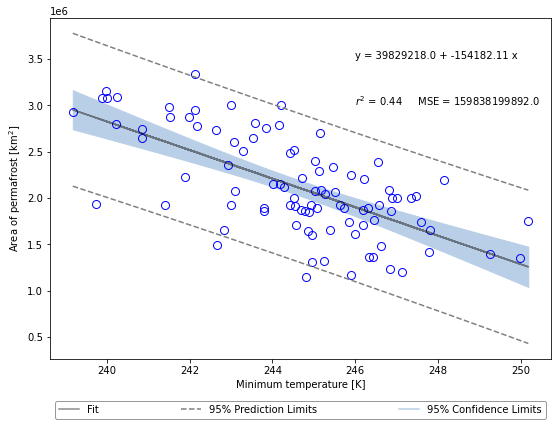

In [10]:
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

def equation(a, cov, b):
    """Return a 1D polynomial."""
    return np.polyval([a, cov], b)

x = np.array(TNn_list_min[0:93])
y = np.array(area_list)
p, cov = np.polyfit(x, y, 1)                     # parameters and covariance from of the fit of 1-D polynom.
slope, intercept = p, cov
y_model = np.polyval([slope, intercept], x)                                  # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
x_mean = np.mean(x)
y_mean = np.mean(y)
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                                        # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# calculating the r2
# https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
# Pearson's correlation coefficient
numerator = np.sum((x - x_mean)*(y - y_mean))
denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
correlation_coef = numerator / denominator
r2 = correlation_coef**2

# mean squared error
MSE = 1/n * np.sum( (y - y_model)**2 )

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, cov, x2)

# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(x, y, resid, ax=ax)
   
# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")
ax.set_ylabel("Area of permafrost [km$^2$]")
ax.set_xlabel("Minimum temperature [K]")


# rounding and position must be changed for each case and preference
a = str(np.round(intercept))
b = str(np.round(slope,2))
r2s = str(np.round(r2,2))
MSEs = str(np.round(MSE))

ax.text(246, 3.5e6, 'y = ' + a + ' + ' + b + ' x')
ax.text(246, 3e6, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)

#plt.show()

handles, labels = ax.get_legend_handles_labels()
display = (0, 1)
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
    [label for i, label in enumerate(labels) if i in display] + ["95% Confidence Limits"],
    loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand"
)  
frame = legend.get_frame().set_edgecolor("0.5")

# Save Figure
plt.tight_layout()
plt.savefig(r"C:\Users\rhonda\OneDrive\Dokumente\Uni-DESKTOP-8400FCB\Master Thesis\Figures for Paper\ED_Figure_11.jpg", bbox_extra_artists=(legend,), bbox_inches="tight")

plt.show()

Store data in csv file.

In [11]:
import pandas as pd
d = dict(x = x, y = y)
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
# df.to_excel(r'C:\Users\rhonda\OneDrive\Dokumente\Uni-DESKTOP-8400FCB\Master Thesis\Excel_Files\ED_Fig_3.xlsx', index = False)




from openpyxl import load_workbook

path = r"C:\Users\rhonda\OneDrive\Dokumente\Uni-DESKTOP-8400FCB\Master Thesis\Excel_Files\Source_Data.xlsx"

book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book


df.to_excel(writer, sheet_name = 'ED_Figure_11')
writer.close()